In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import json 
import ast
import random
import spacy


from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from nltk.corpus import wordnet

#Scikit imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

# Load WordNet synsets for each season-related category
summer_synsets = wordnet.synsets('summer')
winter_synsets = wordnet.synsets('winter')
fall_synsets = wordnet.synsets('fall')
spring_synsets = wordnet.synsets('spring')
# Extract words from synsets
summer_words = set([lemma.name() for synset in summer_synsets for lemma in synset.lemmas()])
winter_words = set([lemma.name() for synset in winter_synsets for lemma in synset.lemmas()])
fall_words = set([lemma.name() for synset in fall_synsets for lemma in synset.lemmas()])
spring_words = set([lemma.name() for synset in spring_synsets for lemma in synset.lemmas()])
# Combine all seasonal words into one list
all_seasonal_words = list(summer_words.union(winter_words, fall_words))

# Filter the list to include only words found in WordNet
valid_seasonal_words = [word for word in all_seasonal_words if wordnet.synsets(word)]

# Print the valid seasonal words
#print("Valid Seasonal Words:", valid_seasonal_words)

nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('Data/movie.metadata.genres.tsv', sep='\t')

**Lexicon explanation**

We first build up a lexicon linked to temporality. We do it with the help of ChatGPT, and we completed it by hand. We then expand it with the synonyms of the words already in. We end up with a lexicon containing over 1200 words, which are close to the topic we focus on. 

**Text processing**

Since one line of the document contains the id and the summary of one movie, we decide to process the whole text line by line. For each line we start by splitting it between the movieID and the summary, to save the movieID in a different array before performing the textual analysis on the summary. For each word of the summary, we frist check if its lemma belongs to our lexicon. If it does we add it to our list of tokens. This step performs lemmatization as well as "feature selection" : we only keep the words we are interested in and therefore avoid giving importance to the punctuation, to the parasite formatting expressions (for instance {{Plot}} written at the beginning of certain lines) and to irrelevant words, including the stopwords and the ones that are not linked to any of the temporality-related words we picked for our lexicon. At the end of this process, we add the movie to our bag-of-words only if it contains at least one of the words present in the lexicon. 

**BOW matrix handling** 

Since we are not particularly interested in words appearing in some specofic summaries only, we decide not to perform the tf-idf transformation. However, we still normalize each line of the BOW by the total number of words, to mitigate the variations of the summaries' length. The final step is to add the movieID column to this dataframe, to make the merging possible with movie.metadata.genres. 



In [3]:
print(df.shape)

(41855, 15)


In [4]:
### A mettre dans le helpers ###

#from nltk.corpus import wordnet
from itertools import chain


# Spring-related words
spring_lexicon = [
    'blossom', 'bloom', 'thaw', 'rain', 'sprout', 'garden', 'sunshine',
    'renewal', 'fresh', 'growth', 'bud', 'warmth', 'green', 'nature',
    'cherry', 'lilac', 'daffodil', 'tulip', 'pastel', 'bees', 'butterfly',
    'songbird', 'new','life', 'sunbeam', 'gentle','breeze', 'blossom', 'spring','reborn'
]

# Summer-related words
summer_lexicon = [
    'sunshine', 'heat', 'beach', 'vacation', 'barbecue', 'swim', 'sunny',
    'warm', 'leisure', 'picnic', 'relaxation', 'holiday', 'tan',
    'surfing', 'sandcastle', 'palm', 'ice_cream', 'flip_flops', 'sunglasses','summer',
    'heatwave', 'fireworks', 'tropical', 'sundress', 'sunset', 'poolside', 'independence'
]

# Autumn (Fall)-related words
autumn_lexicon = [
    'foliage', 'harvest', 'cool', 'pumpkin', 'cider', 'crisp', 'colorful',
    'sweater', 'apple', 'acorn', 'cozy', 'spice', 'hayride', 'autumnal',
    'cornucopia', 'cranberry', 'cornmaze', 'fireside', 'windy','atumn',
    'hoodie', 'mushroom', 'chestnut', 'sweater','weather', 'mild_temperature', 'plaid','orange','leaves','halloween'
]

# Winter-related words
winter_lexicon = [
    'snow', 'frost', 'ice', 'holiday', 'fireplace', 'cozy', 'festive', 'chill', 'Hanukkah',
    'mitten', 'scarf', 'celebrate', 'snowflake', 'hibernate', 'wonderland',
    'icicle', 'penguin', 'mittens', 'cocoa', 'blanket','ski','chairlift','christmas','santa','claus','romantic','valentine','roses','sex'
    'evergreen', 'frosty_morning', 'winter','solstice', 'snowstorm', 'jingle', 'toasty', 'snowy'
]

# Original winter lexicon
#winter_lexicon = ["winter", "cold", "snow", "ice", "frost", "freeze", "chill", "holiday", "hibernate", "storm", "blizzard", "fireplace"]

# Valentine's Day related words
valentines_day_lexicon = ["valentine", "romance", "cupid",  "flowers"]

# Christmas related words
christmas_lexicon = ["christmas", "holiday", "santa", "gift", "tree", "ornament", "jingle", "bell", "sleigh", "merry"]

# New Year's related words
new_years_lexicon = ["new year", "celebrate", "countdown", "party", "fireworks", "resolution"]

halloween_lexicon = ["halloween", "spooky", "ghost", "witch", "pumpkin", "candy", "costume", "trick", "haunt", "skeleton","fear","scared","horror"]

autumn_celebrations_lexicon = ["autumn", "Thanksgiving", "Halloween", "harvest", "turkey", "pilgrims"]

spring_celebrations_lexicon = ["spring", "Easter", "Passover", "blossom", "renewal", "bunny", "egg","chocolate"]


# Combine all lexicons
winter_lexicon = winter_lexicon + valentines_day_lexicon + christmas_lexicon + new_years_lexicon

autumn_lexicon = autumn_lexicon + autumn_celebrations_lexicon+halloween_lexicon

spring_lexicon = spring_lexicon + spring_celebrations_lexicon

# Combine all lexicons
season_lexicon = spring_lexicon + summer_lexicon + autumn_lexicon + winter_lexicon



# Function to get synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Expand the season-related lexicons with synonyms
expanded_spring_lexicon = list(chain.from_iterable([spring_word] + get_synonyms(spring_word) for spring_word in spring_lexicon))
expanded_summer_lexicon = list(chain.from_iterable([summer_word] + get_synonyms(summer_word) for summer_word in summer_lexicon))
expanded_autumn_lexicon = list(chain.from_iterable([autumn_word] + get_synonyms(autumn_word) for autumn_word in autumn_lexicon))
expanded_winter_lexicon = list(chain.from_iterable([winter_word] + get_synonyms(winter_word) for winter_word in winter_lexicon))

# Combine all expanded lexicons
expanded_season_lexicon = expanded_spring_lexicon + expanded_summer_lexicon + expanded_autumn_lexicon + expanded_winter_lexicon

print(len(expanded_season_lexicon))


1238


In [5]:
### Pas important ###
lex_test = ['winter','summer','spring','christmas','halloween','thanksgiving','easter','ski','pool','spring','valentine','cupid','autumn','pumpkin','skeleton','horror','turkey','ghost','santa','cozy','hannukah','solstice','mittens','gloves','beannie','coat','swimshort','bikini','tan','sunset']

In [6]:
### Pas important ###

reduced_lexicon = christmas_lexicon + new_years_lexicon + valentines_day_lexicon + halloween_lexicon + autumn_celebrations_lexicon + spring_celebrations_lexicon
print(len(reduced_lexicon))

47


In [7]:
### A mettre dans le rapport ###

with open('Data/plot_summaries.txt', 'r') as file:
    corpus = file.read()

# Print or use the file contents as needed
#print(file_contents)

lines_plots = corpus.strip().split('\n')
#random_lines = random.sample(lines_plots, k=10000)

In [8]:
### Pas important ###
small_rand = random.sample(lines_plots, k=1000)

In [892]:
### A mettre dans le rapport ###

'''

# Sample corpus
# Tokenization and stopword removal


corpus_bis = """
23890098 Shlykov, $10,000 a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
31186339 The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute.
# ... (add other summaries)
"""

stop_words = set(stopwords.words('english'))
'''
tokenized_summaries = {}
movie_ids = []

processed_corpus = []
for line in lines_plots:
    # Split each line into movie ID and summary
    parts = re.split('[\t ]', line, 1)
    if len(parts) == 2:
        movie_id, summary = parts
        movie_id = int(movie_id)
        if movie_id in df['Wikipedia movieID'].values:  
            #stemmed_words = [porter.stem(word) for word in words] 
            doc = nlp(summary)
            processed_tokens=[]
            for token in doc:               
                if token.lemma_ in expanded_season_lexicon:
                    processed_tokens.extend([token.lemma_])  
            if len(processed_tokens)>0:
                movie_ids.append(movie_id)
                processed_summary = ' '.join(processed_tokens)# for token in doc if token in expanded_season_lexicon])# and token.pos_ != '-PRON-'])
                processed_corpus.append(processed_summary)
            
# Create Bag-of-Words matrix with movie IDs as the first column
            
#tfidf_vectorizer = TfidfVectorizer(norm='l1',min_df=3)
#tfidf_matrix = tfidf_vectorizer.fit_transform(processed_corpus)



# Display movie IDs associated with each row
#print("\nMovie IDs:")
#print(movie_ids)


# Display movie IDs associated with each row
#print("\nMovie IDs:")
#print(movie_ids)


In [893]:
### A mettre dans le rapport ###

vectorizer = CountVectorizer()

bow_matrix = vectorizer.fit_transform(processed_corpus)

bow_array = bow_matrix.toarray()
matrix = bow_array
# Normalize each row by the number of elements
matrix = np.divide(bow_array, bow_array.sum(axis=1, keepdims=True))
MAT = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())
MAT.insert(0, 'Movie ID', movie_ids)
MAT.to_csv('BOW.csv', index=False)

MAT = pd.read_csv('Data/BOW.csv', header=0)

In [10]:
MAT = pd.read_csv('Data/BOW.csv', header=0)

In [11]:
### Pas important ###

# Keep only certain columns in the MAT DataFrame
#MAT_filtered = MAT[[word for word in reduced_lexicon if word in MAT.columns]]
# Remove rows of zeros
#MAT_filtered.head()
#non_zero_rows = MAT_filtered.any(axis=1)
#MAT_filtered_non_zero = MAT_filtered[non_zero_rows]

# Save indices of rows with zeros
#zero_rows_indices = MAT_filtered[~non_zero_rows].index
#print(zero_rows_indices)
print(matrix.shape)
#print(movie_ids)

MAT.head()
MAT.to_csv('BOW.csv', index=False)


NameError: name 'matrix' is not defined

# ICI FAUT INTERCALER TA PARTIE

In [905]:
### Pas important ###
Y = []
X = matrix 
for movie_id in movie_ids:
    if movie_id in df['Wikipedia movieID'].values:
        #print(movie_id)
        #print(df.loc[df['Wikipedia movieID'] == movie_id]['Genre'])

        Y.append(df.loc[df['Wikipedia movieID'] == movie_id]['Movie release season'].values[0])

#Y = [0 if y != 3 else 1 for y in Y]

print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

[4, 2, 2, 4, 3, 2, 1, 1, 4, 1, 4, 4, 1, 4, 1, 4, 2, 4, 2, 4, 1, 1, 4, 2, 3, 3, 1, 3, 2, 4, 2, 3, 4, 4, 1, 2, 4, 4, 4, 1, 4, 2, 2, 3, 3, 3, 2, 1, 2, 3, 1, 4, 4, 3, 4, 2, 1, 3, 4, 1, 1, 3, 3, 4, 2, 4, 3, 4, 3, 2, 2, 3, 3, 4, 2, 3, 4, 2, 4, 3, 1, 2, 2, 4, 1, 2, 2, 4, 3, 2, 4, 1, 2, 1, 4, 2, 2, 3, 2, 2, 4, 1, 4, 1, 3, 4, 4, 2, 2, 3, 1, 2, 2, 2, 4, 1, 3, 3, 4, 1, 2, 3, 1, 4, 2, 1, 3, 3, 3, 4, 2, 4, 4, 3, 1, 4, 2, 4, 4, 2, 2, 1, 1, 2, 1, 3, 4, 2, 3, 1, 1, 2, 3, 3, 3, 1, 4, 2, 2, 1, 2, 1, 1, 1, 1, 4, 2, 2, 1, 4, 1, 3, 2, 2, 4, 2, 4, 3, 1, 4, 2, 3, 4, 4, 1, 4, 2, 4, 3, 3, 2, 3, 4, 4, 2, 3, 4, 4, 2, 4, 1, 1, 2, 4, 1, 4, 3, 2, 1, 1, 4, 4, 4, 3, 2, 3, 1, 2, 4, 4, 4, 2, 2, 4, 1, 3, 2, 3, 2, 1, 2, 4, 2, 2, 2, 1, 4, 2, 3, 1, 2, 1, 4, 3, 1, 2, 1, 2, 4, 1, 4, 2, 2, 4, 2, 1, 2, 3, 3, 4, 1, 2, 2, 2, 4, 2, 3, 1, 4, 1, 2, 2, 3, 1, 4, 1, 1, 2, 1, 3, 4, 1, 3, 4, 1, 4, 1, 4, 3, 1, 3, 2, 4, 1, 1, 4, 4, 1, 4, 1, 3, 4, 4, 4, 1, 2, 4, 1, 1, 4, 1, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 2, 4, 1, 3, 2, 2, 1, 4, 3, 4, 1, 

In [943]:
### Pas important ###

# Create a Random Forest classifier
classifier = LogisticRegression(max_iter=1000,random_state=42,C = 1)
#classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# Fit the classifier to the training data
classifier.fit(X_train, Y_train)

#print(predicted_probabilities>=threshold)
# Make predictions on the test datass dx
predictions = classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy:", accuracy)



#report = classification_report(Y_test, predictions,zero_division=1)

# Print the report


#print(report)

Accuracy: 0.28416912487708945


In [920]:
### A rajouter dans le rapport ###

random_classifier_scores = []
model_scores=[]
for i in range(len(predictions)):   
    if predictions[i] == Y_test[i]:
        model_scores.append(1)
    else:
        model_scores.append(0)
    ran = random.randint(1,4)
    if ran == Y_test[i]:
        random_classifier_scores.append(1)
    else:
        random_classifier_scores.append(0)


t_statistic, p_value = stats.ttest_ind(random_classifier_scores, model_scores)

print("p-value", p_value)
print(f"Accuracy: {accuracy} p-value: {p_value} significant: {p_value < 0.05}")
##################################

p-value 0.00013680876024636877


In [921]:
### Pas important ###

random_classifier_accuracy = 0.25
model_accuracy = accuracy 

# Number of samples (e.g., number of experiments or runs)
num_samples = int(len(Y_test)*10)  # Adjust as needed

# Generate random accuracy scores for a random classifier
random_classifier_scores = np.random.binomial(1, random_classifier_accuracy, num_samples)

# Generate accuracy scores for your model
model_scores = np.random.binomial(1, model_accuracy, num_samples)

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(random_classifier_scores, model_scores)
print(f"Accuracy: {accuracy} p-value: {p_value} significant: {p_value < 0.05}")

Accuracy: 0.28416912487708945 p-value: 1.070230075755778e-38 significant: True


In [922]:
### Pas important ###

p = 0
for y in predicted_labels:
    #print(y)
    if y == 1:
        p+=1

print(p)

94


In [923]:
### Pas important ###

print(vectorizer.get_feature_names_out())

['acorn' 'adorn' 'affectionate' 'air' 'alert' 'allow' 'amor' 'amorous'
 'animation' 'answer' 'antic' 'aplomb' 'appease' 'apple' 'ardent'
 'aristocratic' 'assuage' 'autumn' 'autumnal' 'awe' 'ball' 'bamboozle'
 'barbecue' 'be' 'beach' 'bee' 'beldam' 'bell' 'bequeath' 'bewitch'
 'biography' 'blanket' 'blessing' 'blizzard' 'bloom' 'blooming' 'blossom'
 'blow' 'blue' 'blush' 'bollock' 'bomb' 'bounce' 'bound' 'brave' 'breeze'
 'breezy' 'broad' 'bronze' 'browse' 'bud' 'bunny' 'burn' 'butterfly'
 'buzzer' 'candy' 'caper' 'care' 'celebrate' 'chalk' 'chanukah' 'cheer'
 'cheerfulness' 'cheery' 'cherry' 'chestnut' 'chill' 'chime' 'chip'
 'chocolate' 'christmas' 'christmastime' 'cider' 'cinch' 'clean' 'closure'
 'cocoa' 'coffee' 'coke' 'colored' 'colorful' 'coloured' 'colourful'
 'common' 'company' 'comprise' 'concern' 'conjuration' 'constitute'
 'converted' 'cool' 'coquette' 'corner' 'cornucopia' 'cost' 'costume'
 'cosy' 'countdown' 'court' 'cover' 'cozy' 'cranberry' 'crank' 'crease'
 'crimson' 'c

In [926]:
### Pas important ###

coefs=classifier.coef_[0]
top_three = np.argpartition(coefs, -5)[-5:]

print(np.array(vectorizer.get_feature_names_out())[top_three])

['snow' 'replacement' 'swimming' 'christmas' 'holiday']


In [ ]:
import numpy as np
from scipy import stats

In [924]:
### Pas important ###

random_classifier_accuracy = 0.25
model_accuracy = accuracy 

# Number of samples (e.g., number of experiments or runs)
num_samples = int(MAT.shape[0]*0.25)  # Adjust as needed

# Generate random accuracy scores for a random classifier
random_classifier_scores = np.random.binomial(1, random_classifier_accuracy, num_samples)

# Generate accuracy scores for your model
model_scores = np.random.binomial(1, model_accuracy, num_samples)

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(random_classifier_scores, model_scores)
print(f"Accuracy: {accuracy} p-value: {p_value} significant: {p_value < 0.05}")

Accuracy: 0.28416912487708945 p-value: 7.058143937796748e-10 significant: True


In [932]:
### A mettre dans le rapport pour faire monter la tension ###

accs= [0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.35]

num_samples = int(23700*0.2)

for acc in accs:
    
    model_scores = np.random.binomial(1, acc, num_samples)
    t_statistic, p_value = stats.ttest_ind(random_classifier_scores, model_scores)
    print(f"Accuracy: {acc} p-value: {p_value} significant: {p_value < 0.05}")

# Check the p-value against the significance level

#print(p_value)
#print(random_classifier_scores)
alpha = 0.05



Accuracy: 0.25 p-value: 0.3552819546261291 significant: False
Accuracy: 0.26 p-value: 0.0003945974115492465 significant: True
Accuracy: 0.27 p-value: 0.001913054813950234 significant: True
Accuracy: 0.28 p-value: 0.0001521655760673669 significant: True
Accuracy: 0.29 p-value: 2.1438872609916505e-05 significant: True
Accuracy: 0.3 p-value: 6.493501060928983e-11 significant: True
Accuracy: 0.31 p-value: 1.5198039270358848e-11 significant: True
Accuracy: 0.32 p-value: 9.936606392392386e-17 significant: True
Accuracy: 0.33 p-value: 2.998378361662111e-20 significant: True
Accuracy: 0.35 p-value: 5.459824456193085e-35 significant: True


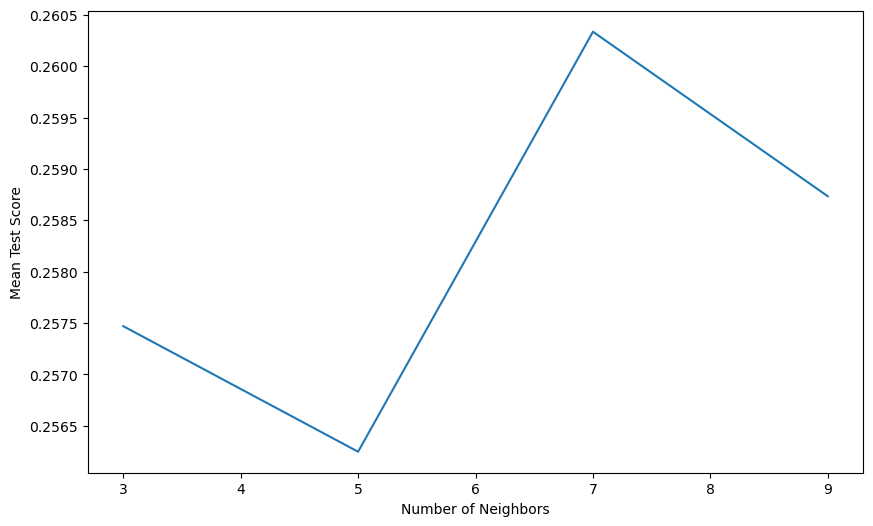

/Users/adm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

AttributeError: 'dict' object has no attribute 'cv_results_'

<Figure size 1000x600 with 0 Axes>

In [939]:
### Pas important ###

# Example for KNN
knn_param_grid = {'n_neighbors': [3, 5, 7,9]}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, scoring='accuracy')
knn_grid_search.fit(X, Y)
plt.figure(figsize=(10, 6))
plt.plot(knn_param_grid['n_neighbors'], knn_grid_search.cv_results_['mean_test_score'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.show()


# Example for Logistic Regression
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
logreg_grid_search = GridSearchCV(LogisticRegression(), logreg_param_grid, scoring='accuracy')
logreg_grid_search.fit(X, Y)
plt.figure(figsize=(10, 6))
plt.plot(logreg_param_grid['C'], logreg_param_grid.cv_results_['mean_test_score'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.show()

# Example for Random Forest
rf_param_grid = {'n_estimators': [50,100,150,200]}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, scoring='accuracy')
rf_grid_search.fit(X, Y)
plt.figure(figsize=(10, 6))
plt.plot(rf_param_grid['n_estimators'], rf_param_grid.cv_results_['mean_test_score'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.show()

#best_rf_model = rf_grid_search.best_estimator_


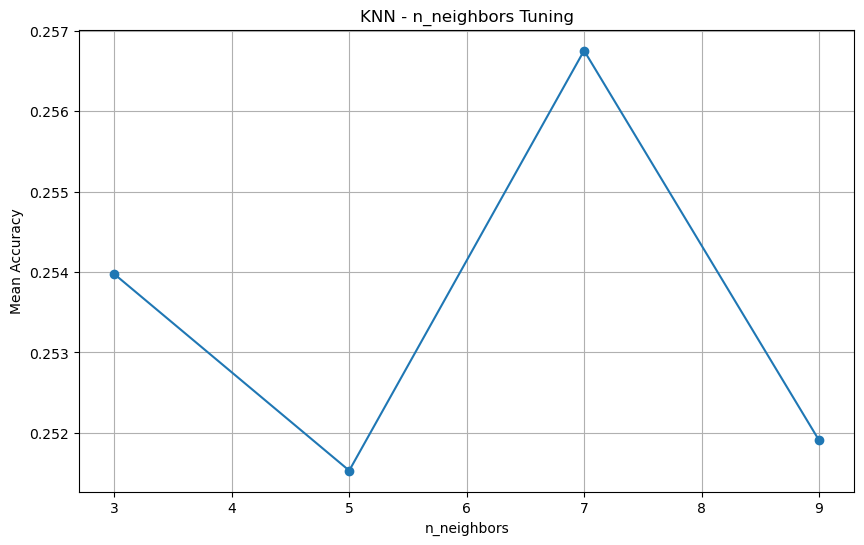

/Users/adm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adm/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

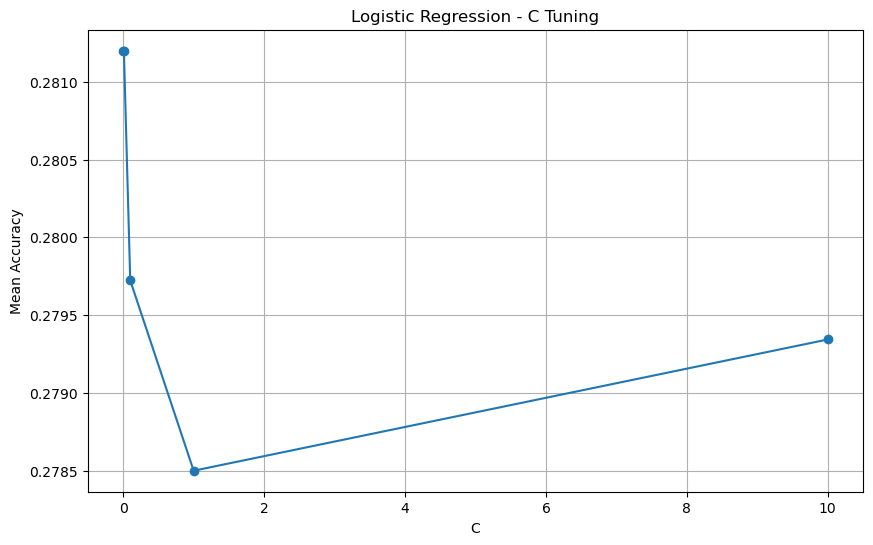

In [941]:
### A rajouter dans le rapport (long à run) ###
### Hyperparameter Tuning ###

kf = 5

# Define a function for hyperparameter tuning and plotting
def tune_and_plot(model, param_grid, model_name, param_name, X, Y):
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
    grid_search.fit(X, Y)
    
    # Extract the relevant information from the results
    param_values = param_grid[param_name]
    mean_scores = grid_search.cv_results_['mean_test_score']
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, mean_scores, marker='o')
    plt.title(f'{model_name} - {param_name} Tuning')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)
    plt.show()

# Hyperparameter tuning and plotting for KNN
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
tune_and_plot(KNeighborsClassifier(), knn_param_grid, 'KNN', 'N neighbors', X, Y)

# Hyperparameter tuning and plotting for Logistic Regression
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
tune_and_plot(LogisticRegression(max_iter=1000), logreg_param_grid, 'Logistic Regression', 'C', X, Y)

rf_param_grid = {'n_estimators': [50,100,150,200]}
tune_and_plot(RandomForestClassifier(), rf_param_grid, 'Random Forest', 'N estimators', X, Y)

##################################


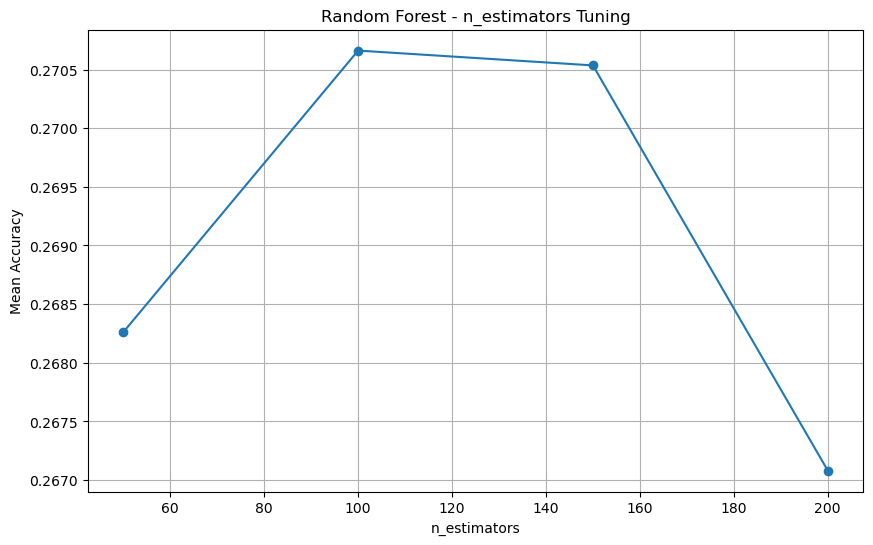

In [945]:
rf_param_grid = {'n_estimators': [50,100,150,200]}
tune_and_plot(RandomForestClassifier(), rf_param_grid, 'Random Forest', 'n_estimators', X, Y)


# ICI EXPLIQUER LA PARTIE DE TUNING ET POURQUOI ON CHOISIT LOGISTIC AVEC CE COEFF C 

In [ ]:
### A peut etre rajouter dans le rapport mais pas sûr ###
### K-Fold Cross Validation ###

knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression(max_iter=1000,random_state=42,C = 1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

num_folds = 3  # You can adjust the number of folds as needed
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

knn_scores = cross_val_score(knn_model, X, Y, cv=kf, scoring='accuracy')
logreg_scores = cross_val_score(logreg_model, X, Y, cv=kf, scoring='accuracy')
rf_scores = cross_val_score(rf_model, X, Y, cv=kf, scoring='accuracy')

print(f'KNN Accuracy: {np.mean(knn_scores)} (std: {np.std(knn_scores)})')
print(f'Logistic Regression Accuracy: {np.mean(logreg_scores)} (std: {np.std(logreg_scores)})')
print(f'Random Forest Accuracy: {np.mean(rf_scores)} (std: {np.std(rf_scores)})')

##################################